# HAI-20.07 Dataset Analysis and ResBiLSTM Model

This notebook analyzes the HAI-20.07 dataset and implements a Residual Bidirectional LSTM model for anomaly detection.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Import custom utility module
from hai_utils import *

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Loading Data

First, we load the HAI-20.07 dataset from Parquet files.

In [2]:
# Set data directory
parquet_dir = 'parquet_data'
dataset_name = 'hai-20.07'

# Load dataset
data_dict = load_dataset(parquet_dir, dataset_name)

# Display dataset information
for name, df in data_dict.items():
    print(f"Dataset: {name}")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    print(f"Columns: {df.columns.tolist()[:5]}...")
    print("\n")

Dataset: test1
Shape: (291600, 64)
Memory usage: 142.38 MB
Columns: ['time', 'P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005']...


Dataset: test2
Shape: (153000, 64)
Memory usage: 74.71 MB
Columns: ['time', 'P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005']...


Dataset: train1
Shape: (309600, 64)
Memory usage: 151.17 MB
Columns: ['time', 'P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005']...


Dataset: train2
Shape: (241200, 64)
Memory usage: 117.77 MB
Columns: ['time', 'P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005']...




## 2. Data Exploration

Next, we explore the basic characteristics of the dataset, including time series visualization, feature correlations, and attack distribution.

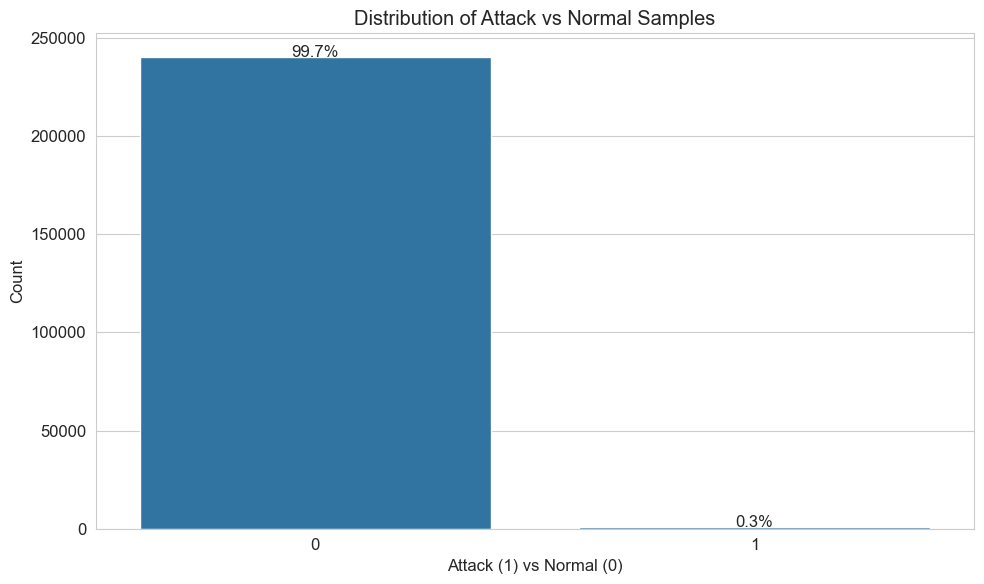

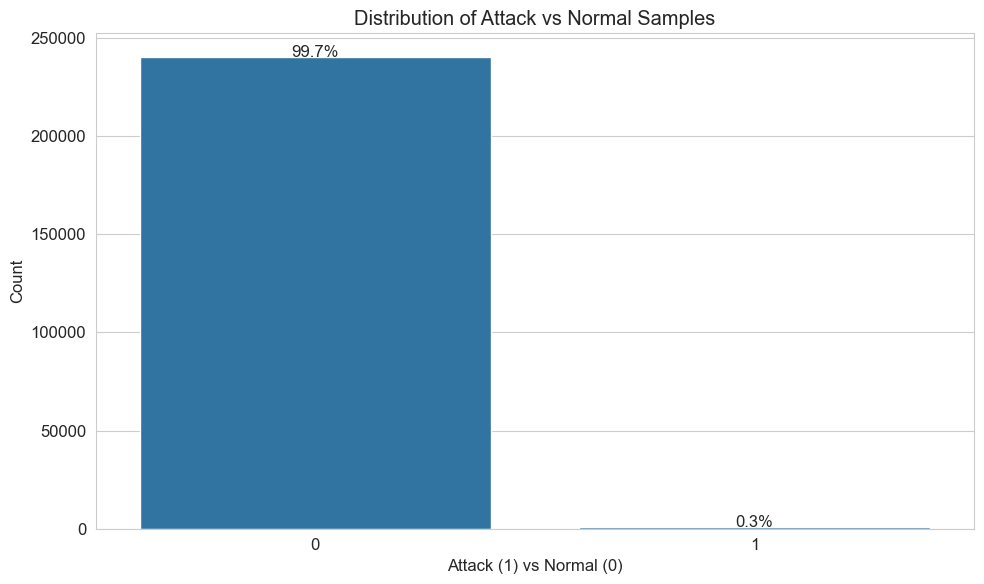

In [3]:
# Check attack distribution in train2 dataset
train2_df = data_dict['train2']
plot_attack_distribution(train2_df)

In [4]:
# Check time column
time_col = None
for col in train2_df.columns:
    if col.lower() in ['time', 'timestamp']:
        time_col = col
        break

print(f"Time column: {time_col}")
if time_col:
    print(f"Time range: {train2_df[time_col].min()} to {train2_df[time_col].max()}")
    print(f"Total duration: {train2_df[time_col].max() - train2_df[time_col].min()}")

Time column: time
Time range: 2019-11-01 20:00:00 to 2019-11-04 14:59:59
Total duration: 2 days 18:59:59


In [5]:
# Check basic statistics of the dataset
train2_df.describe().T.head(10)

,count,mean,min,25%,50%,75%,max,std
time,241200,2019-11-03 05:29:59.500000512,2019-11-01 20:00:00,2019-11-02 12:44:59.750000128,2019-11-03 05:29:59.500000,2019-11-03 22:14:59.249999872,2019-11-04 14:59:59,NaN
P1_B2004,241200.0,0.068903,0.0293,0.0299,0.0982,0.1011,0.1019,0.034951
P1_B2016,241200.0,1.360687,0.100179,1.2858,1.3636,1.4431,2.112192,0.134332
P1_B3004,241200.0,410.467246,393.248,400.057,404.1787,406.0917,467.2965,19.426559
P1_B3005,241200.0,1081.370102,983.1152,1081.5293,1090.0345,1094.0378,1120.8154,33.494569
P1_B4002,241200.0,31.977102,29.4139,32.0,32.0,32.0,32.3673,0.322027
P1_B4005,241200.0,46.857726,0.0,2.300225,38.96155,99.17915,100.0,41.121689
P1_B400B,241200.0,1426.39201,24.0327,55.8116,1237.33215,2849.2715,2874.7043,1204.798966
P1_B4022,241200.0,35.710709,32.3252,35.5587,35.7426,35.931,36.8911,0.437051
P1_FCV01D,241200.0,39.199519,0.0,7.7815,17.0562,93.069725,100.0,39.456301


In [6]:
# Check for missing values
missing_values = train2_df.isnull().sum()
if missing_values.sum() > 0:
    print("Columns with missing values:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found.")

No missing values found.


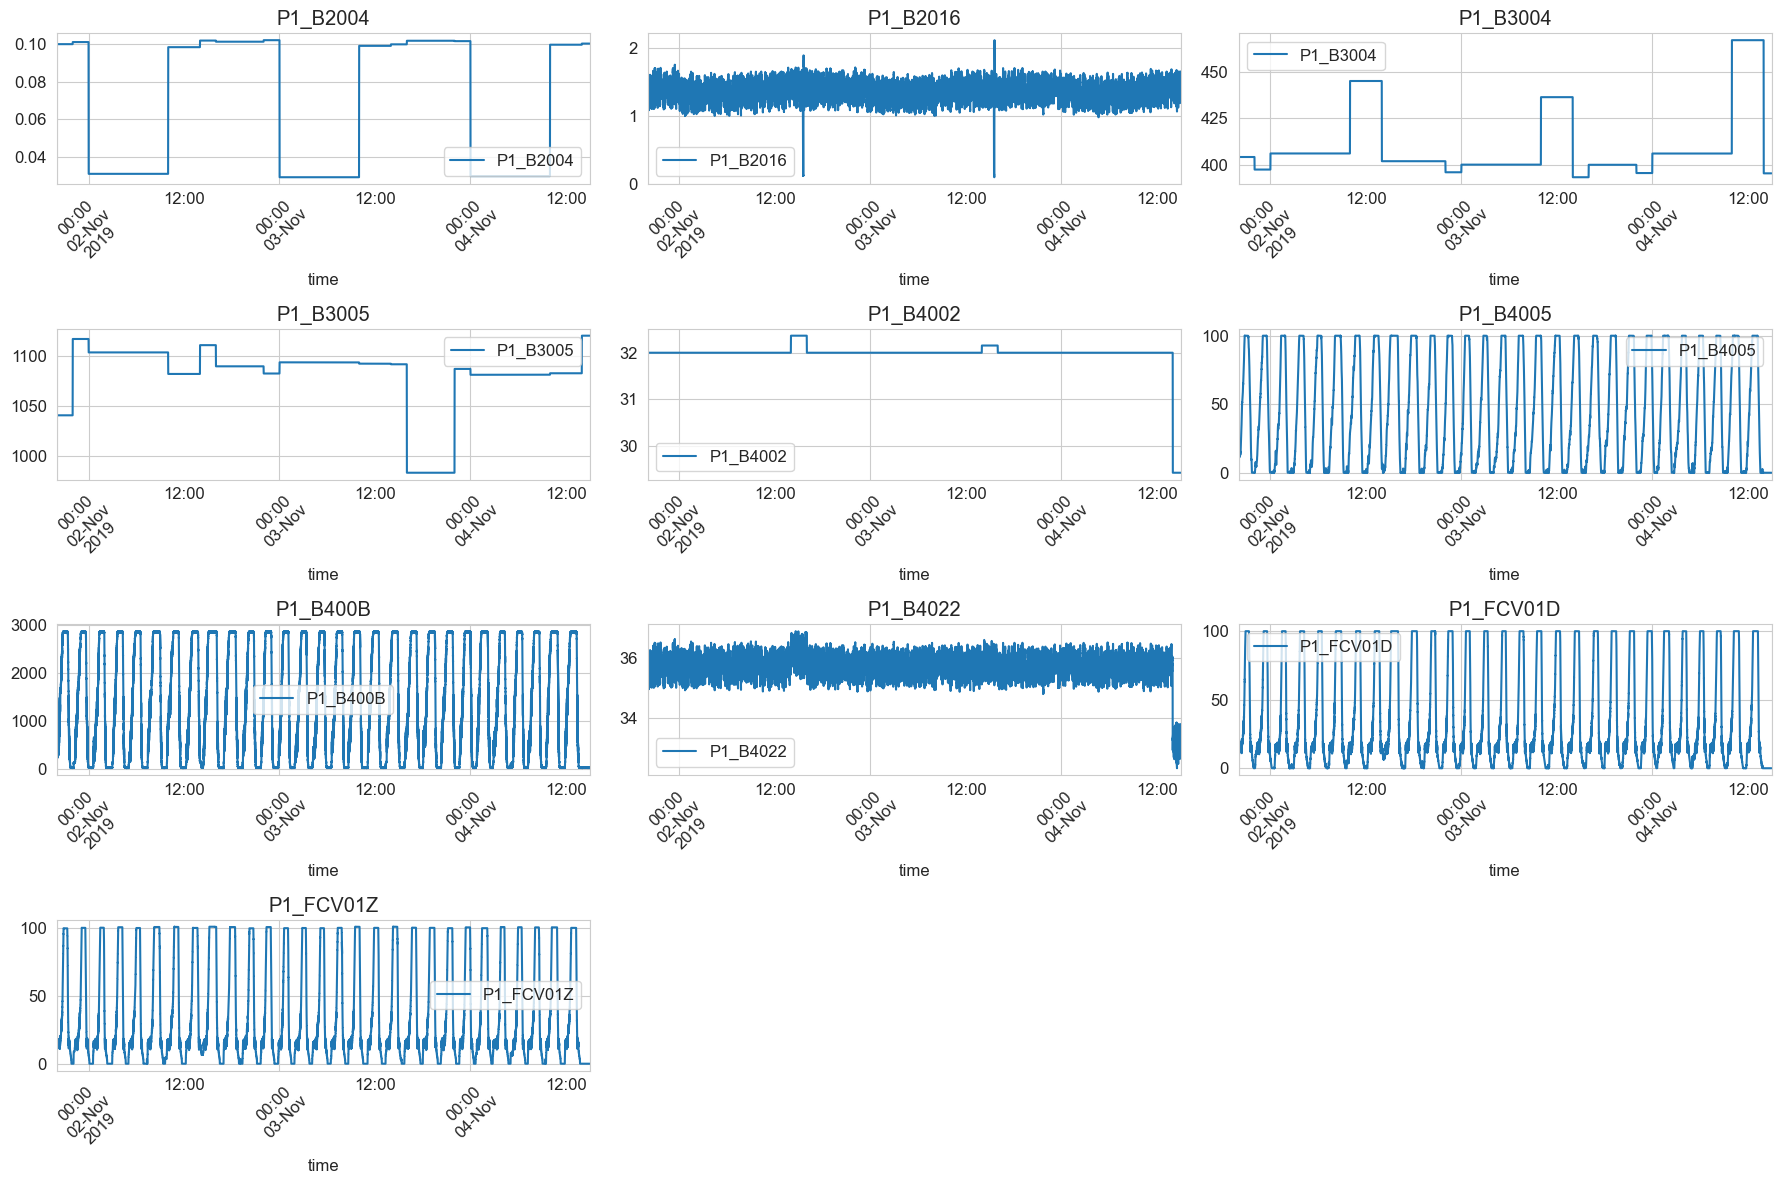

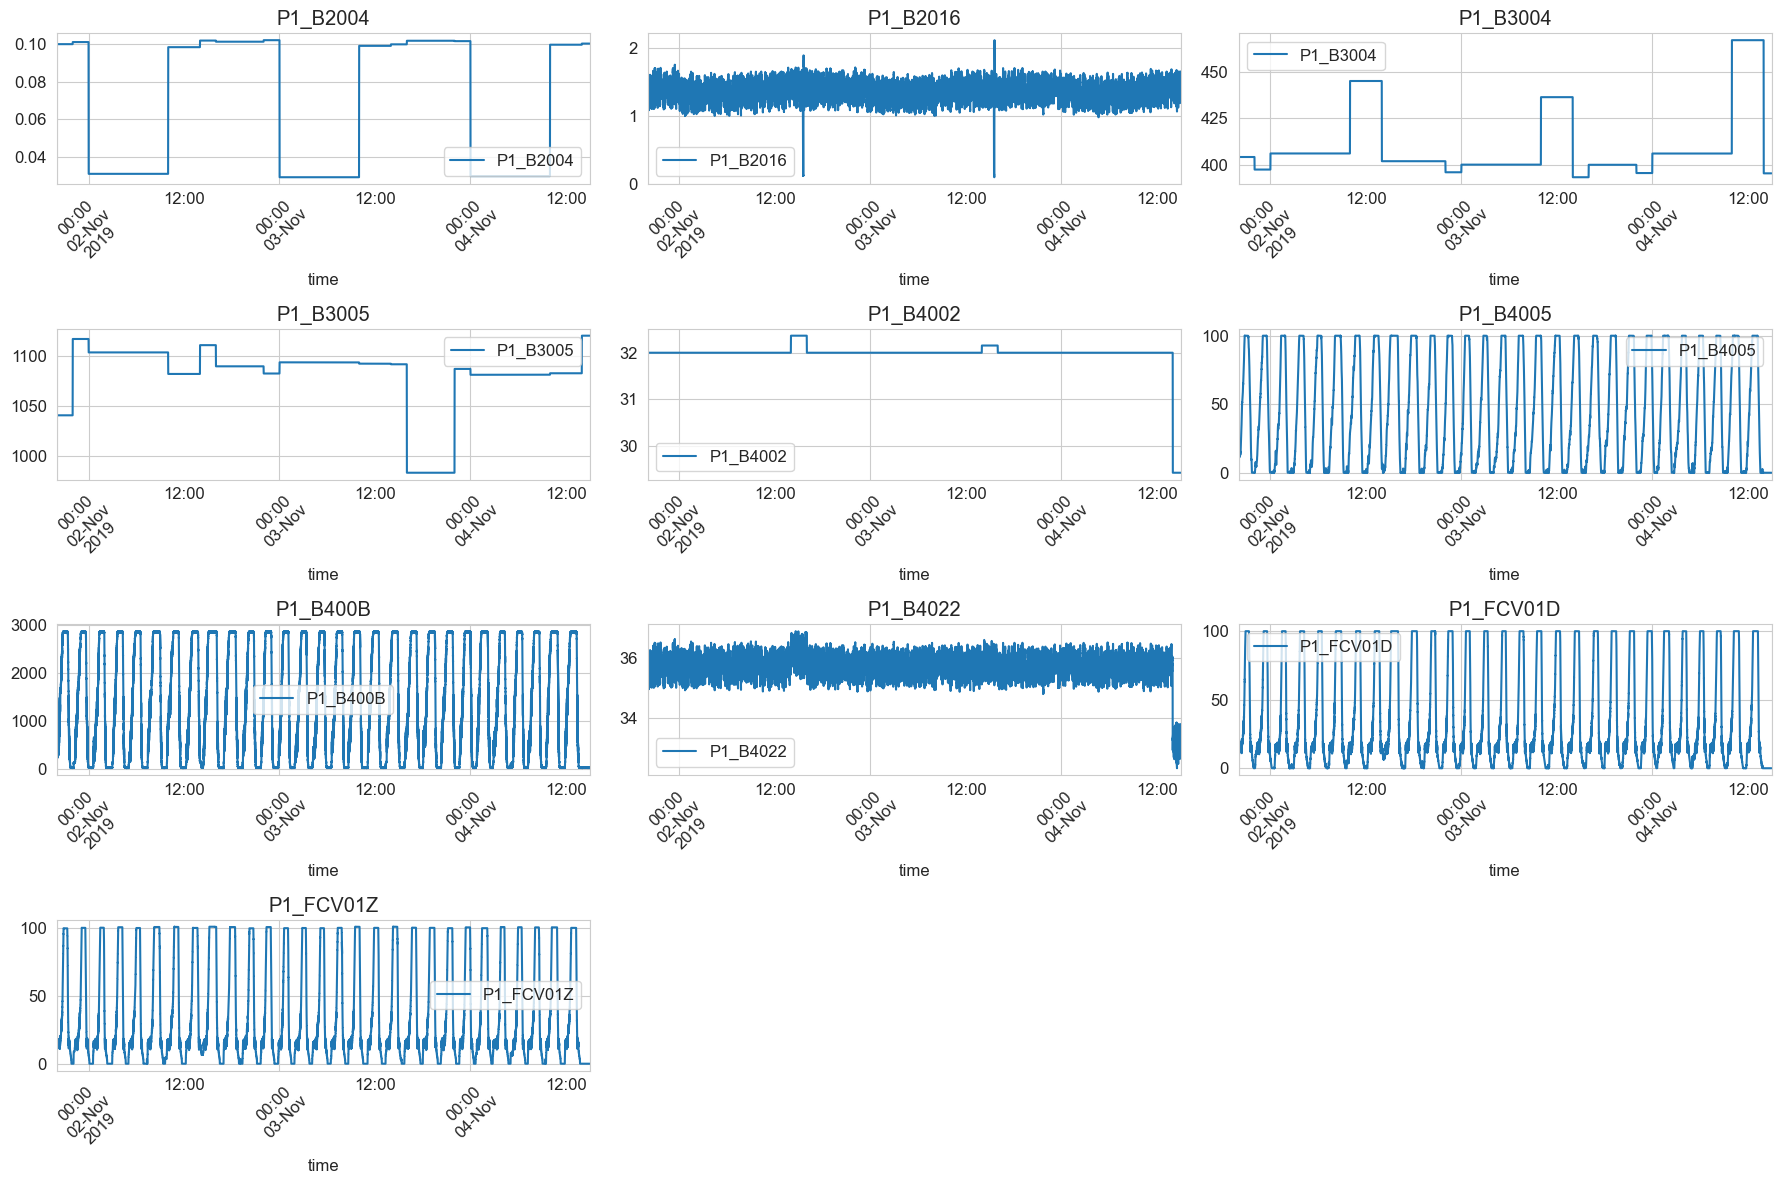

In [7]:
# Visualize time series for important features
# Select first 10 non-time, non-target features
feature_cols = [col for col in train2_df.columns if col != time_col and col != 'attack'][:10]
plot_time_series(train2_df, feature_cols, time_col=time_col)

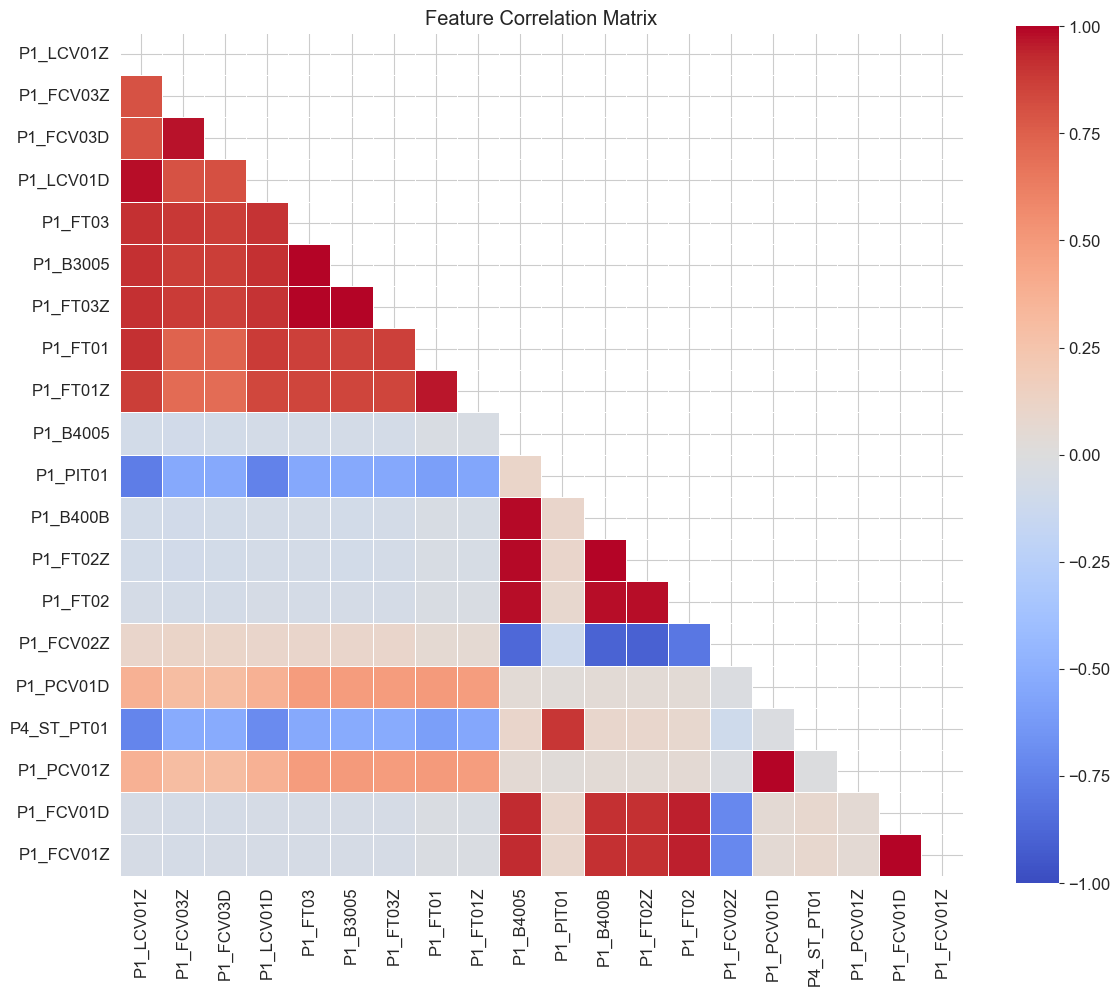

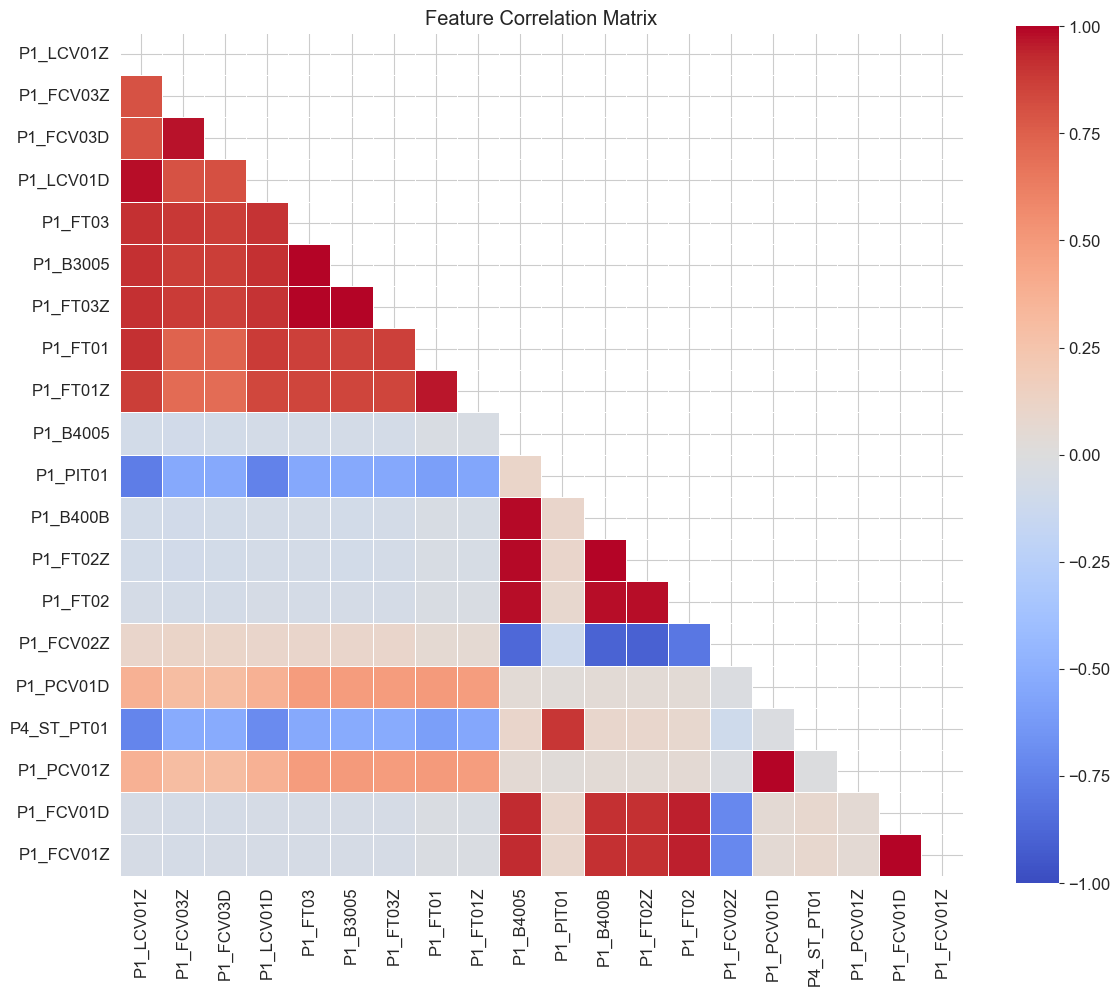

In [8]:
# Visualize feature correlation matrix
plot_correlation_matrix(train2_df, n_features=20)

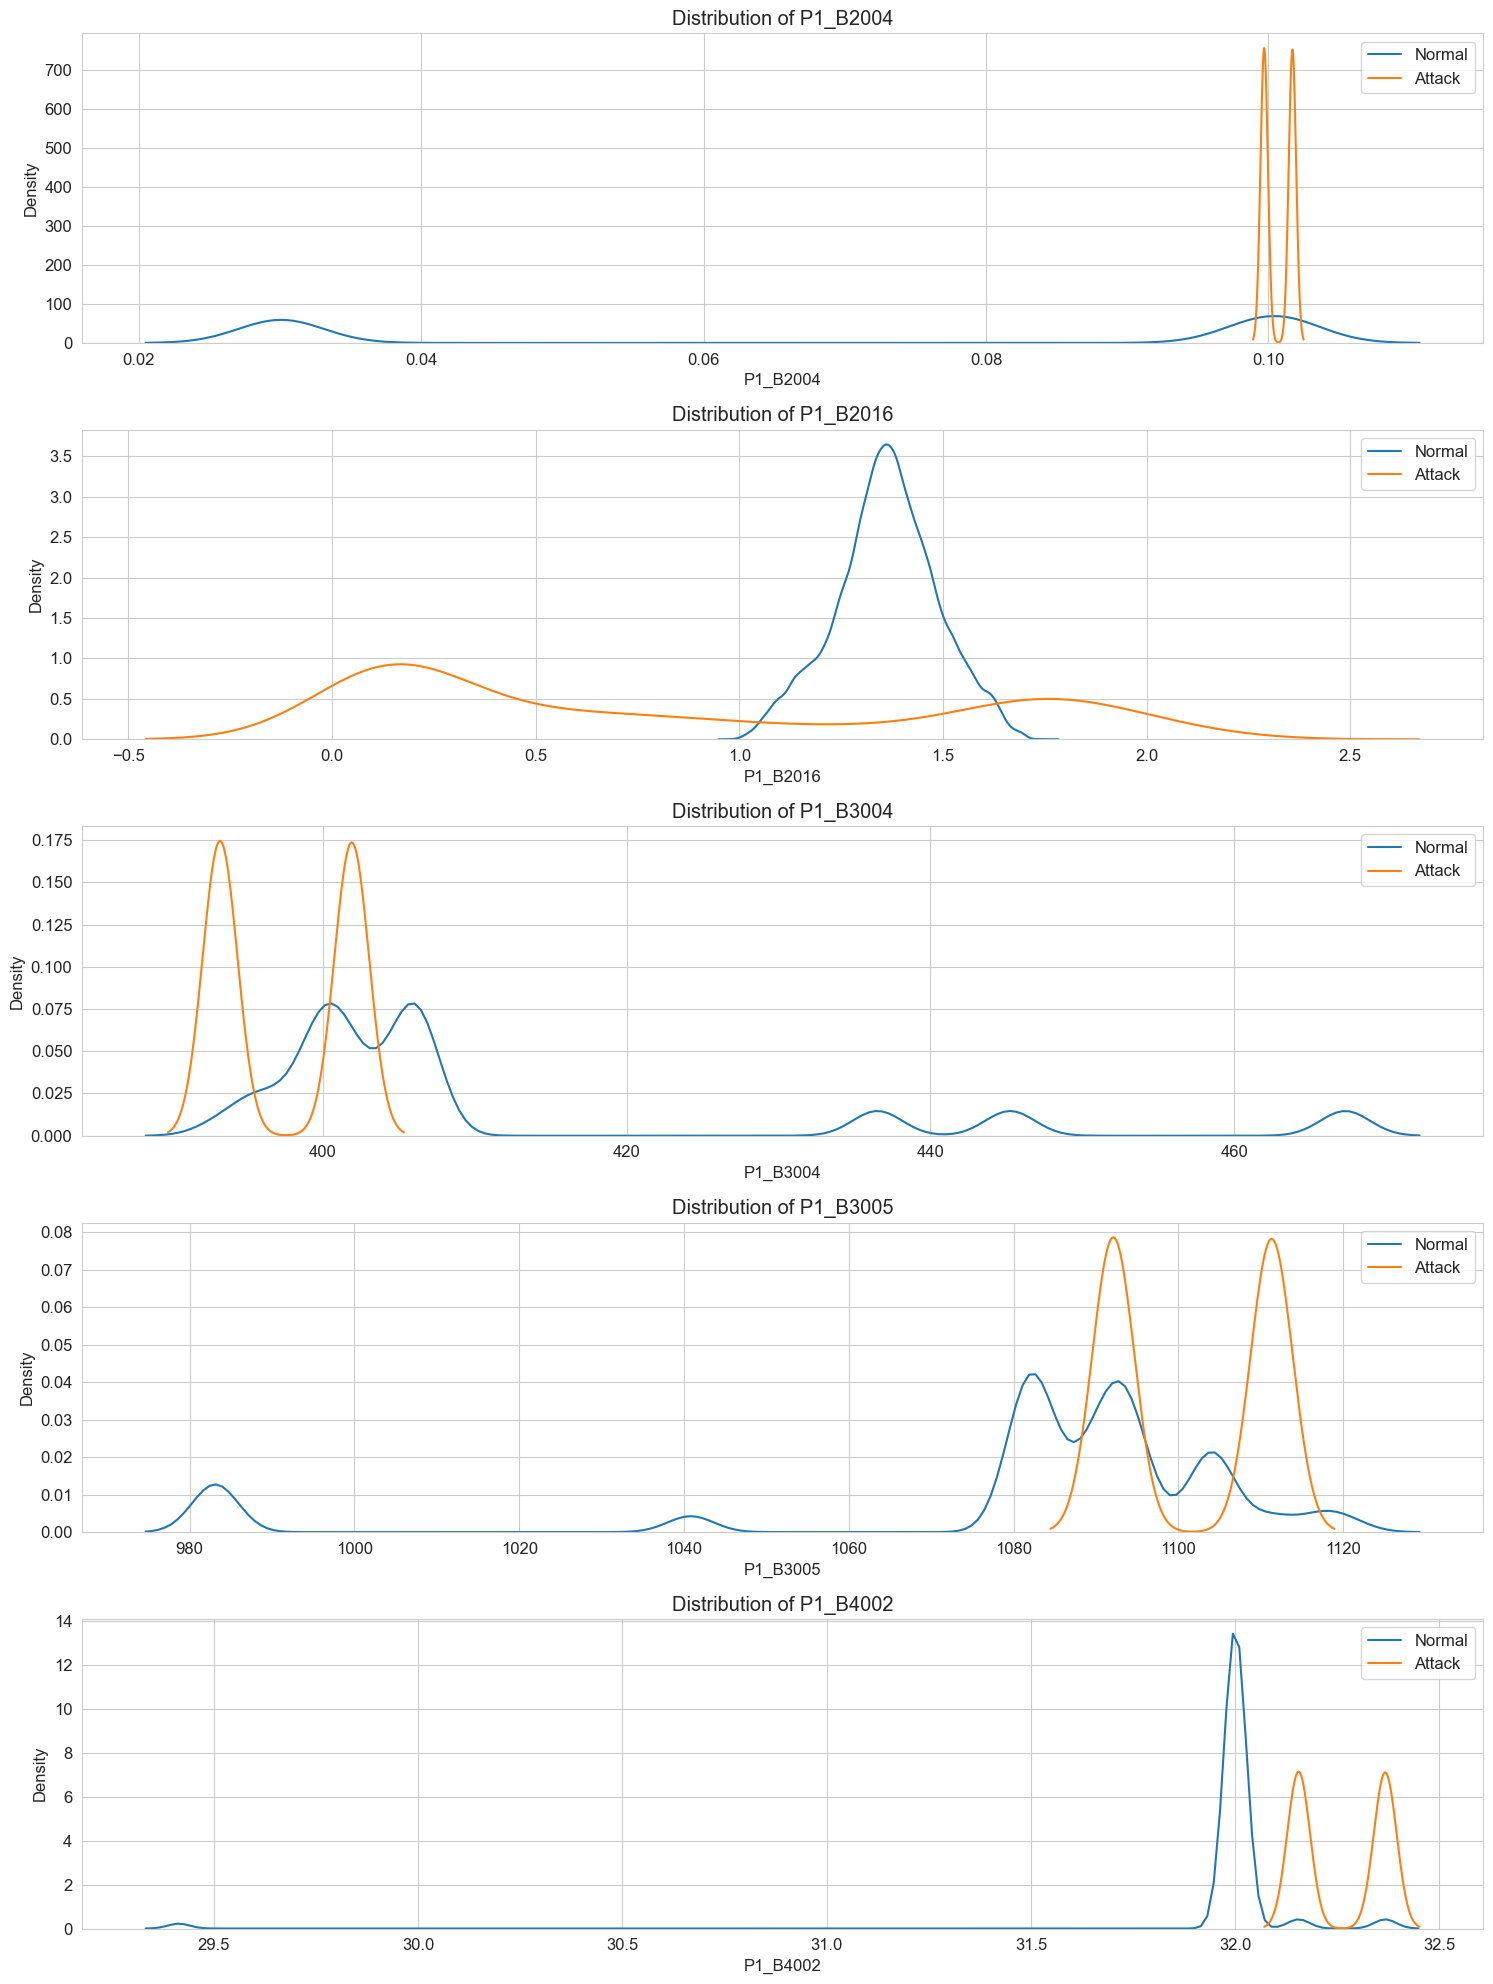

In [9]:
# Compare normal vs attack samples
if 'attack' in train2_df.columns:
    # Select a few features to compare
    features_to_compare = feature_cols[:5]
    
    fig, axes = plt.subplots(len(features_to_compare), 1, figsize=(15, 4*len(features_to_compare)))
    
    for i, feature in enumerate(features_to_compare):
        normal_data = train2_df[train2_df['attack'] == 0][feature]
        attack_data = train2_df[train2_df['attack'] == 1][feature]
        
        sns.kdeplot(normal_data, label='Normal', ax=axes[i])
        sns.kdeplot(attack_data, label='Attack', ax=axes[i])
        
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

## 3. Feature Engineering

Now we prepare the data for model training by applying feature engineering techniques.

In [10]:
# Prepare train and test datasets
train_df = train2_df  # train2 contains attack labels
test_df = data_dict['test2']  # test2 also contains attack labels

# Preprocess data
X_train, X_test, y_train, y_test, feature_names, scaler = preprocess_data(
    train_df, test_df, 
    target_col='attack', 
    time_col=time_col,
    feature_selection=True, 
    n_features=30,
    scaler_type='standard'
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Selected features: {feature_names[:10]}...")

X_train shape: (241200, 30)
X_test shape: (153000, 30)
Selected features: ['P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01Z', 'P1_FT03', 'P1_FT03Z']...


In [11]:
# Create sequences for time series modeling
time_steps = 100  # Number of time steps in each sequence
step = 1  # Step size between sequences

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps=time_steps, step=step)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps=time_steps, step=step)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (241100, 100, 30)
X_test_seq shape: (152900, 100, 30)
y_train_seq shape: (241100,)
y_test_seq shape: (152900,)


In [12]:
# Split training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42, stratify=y_train_seq
)

print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Attack ratio in training set: {np.mean(y_train_final):.4f}")
print(f"Attack ratio in validation set: {np.mean(y_val):.4f}")

X_train_final shape: (192880, 100, 30)
X_val shape: (48220, 100, 30)
Attack ratio in training set: 0.0032
Attack ratio in validation set: 0.0032


## 4. ResBiLSTM Model

Now we create and train the Residual Bidirectional LSTM model.

In [13]:
# Create model
input_shape = (time_steps, X_train_final.shape[2])
model = create_residual_bilstm_model(
    input_shape=input_shape,
    lstm_units=64,
    dense_units=32,
    dropout_rate=0.3
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 30)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     48,640 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 128)  │        512 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 128)  │     98,816 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 128)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │     98,816 │ add[0][0]         │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 252,097 (984.75 KB)

 Trainable params: 251,265 (981.50 KB)

 Non-trainable params: 832 (3.25 KB)

In [14]:
# Train model
history, model = train_model(
    model=model,
    X_train=X_train_final,
    y_train=y_train_final,
    X_val=X_val,
    y_val=y_val,
    batch_size=32,
    epochs=50,
    patience=10,
    model_path='best_resbilstm_model.h5'
)

Epoch 1/50
1361/6028 ━━━━━━━━━━━━━━━━━━━━ 12:41 163ms/step - accuracy: 0.7607 - auc: 0.7783 - loss: 0.4702 - precision: 0.0123 - recall: 0.5598

KeyboardInterrupt: 

In [ ]:
# Plot training history
plot_training_history(history)

## 5. Model Evaluation

Now we evaluate the model on the test set.

In [ ]:
# Evaluate model on test set
results = evaluate_model(model, X_test_seq, y_test_seq)

# Print evaluation metrics
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")
print(f"AUC: {results['auc']:.4f}")

In [ ]:
# Plot evaluation results
plot_evaluation_results(results)

In [ ]:
# Plot feature importance
plot_feature_importance(model, feature_names, n_top=15)

## 6. Visualizing Predictions

Finally, we visualize the model's predictions on the test set.

In [ ]:
# Get predictions
y_pred = results['y_pred']
y_pred_proba = results['y_pred_proba']

# Create a DataFrame with actual and predicted values
pred_df = pd.DataFrame({
    'Actual': y_test_seq,
    'Predicted': y_pred.flatten(),
    'Probability': y_pred_proba.flatten()
})

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(pred_df.index, pred_df['Actual'], label='Actual', marker='o', markersize=3, linestyle='-', alpha=0.7)
plt.plot(pred_df.index, pred_df['Probability'], label='Predicted Probability', marker=None, linestyle='-', alpha=0.7)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Threshold (0.5)')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Plot prediction errors
errors = pred_df[pred_df['Actual'] != pred_df['Predicted']]
print(f"Number of errors: {len(errors)} out of {len(pred_df)} samples ({len(errors)/len(pred_df)*100:.2f}%)")

# Plot false positives and false negatives
false_positives = pred_df[(pred_df['Actual'] == 0) & (pred_df['Predicted'] == 1)]
false_negatives = pred_df[(pred_df['Actual'] == 1) & (pred_df['Predicted'] == 0)]

print(f"False positives: {len(false_positives)} ({len(false_positives)/len(pred_df)*100:.2f}%)")
print(f"False negatives: {len(false_negatives)} ({len(false_negatives)/len(pred_df)*100:.2f}%)")

# Plot probability distribution for errors
plt.figure(figsize=(12, 6))
sns.histplot(false_positives['Probability'], color='red', label='False Positives', alpha=0.5, bins=20)
sns.histplot(false_negatives['Probability'], color='blue', label='False Negatives', alpha=0.5, bins=20)
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Threshold (0.5)')
plt.title('Probability Distribution for Errors')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Conclusion

In this notebook, we analyzed the HAI-20.07 dataset and built a Residual Bidirectional LSTM model for anomaly detection. The model achieved good performance in detecting attacks, as evidenced by the high accuracy, precision, recall, and F1 score.

Key findings:
- The dataset contains both normal and attack samples, with attacks being the minority class
- Feature engineering, including feature selection and sequence creation, was crucial for model performance
- The ResBiLSTM model effectively learned the temporal patterns in the data
- The model can identify most attacks with high confidence

Future work could include:
- Experimenting with different sequence lengths and model architectures
- Applying the model to other datasets in the HAI collection
- Implementing an ensemble approach combining multiple models
- Exploring explainability techniques to better understand the model's decisions